In [1]:
import skimage.measure as msr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd

In [2]:
# import sys
# sys.path.append("..")

In [3]:
# Importing class from wmark.py
from wmark import WaterMark

In [4]:
import glob
import os
from pathlib import Path

In [5]:
# Source Directory
srcFolder = 'TestSet/'
# Source Path
srcPth = Path(srcFolder).resolve()

In [6]:
# All TIF files in the src_path are now imgs
imgs = srcPth.glob('*.tif')

In [7]:
    def impactFactorMetric(img, seed, mask, min_impact = 0.75, max_impact = 4, steps = 25):
        """ Method for calculating dependency between Impact Factor and PSNR/SSIM

        Arguments:
            img {ndarray} -- original (input) image
            min_impact {int} -- minimum logarithmic value of Impact Factor (default: {0.75})
            max_impact {int} -- maximum logarithmic value of Impact Factor (default: {4})
            steps {int} -- jump between two Impact Factor values (default: {25})
            seed {int} -- pseudo-random; for decoding
            mask {bool} -- pseudo-random; for decoding

        Returns:
            pd.DataFrame -- Impact Factor, PSNR, SSIM as a single Pandas DataFrame
        """
        watermark_object = WaterMark(seed)
        range_max = int(steps)
        # range_max = int(max_impact / steps) + 1
        results = np.zeros([range_max, 3])
        impact_factor = np.logspace(min_impact, max_impact, num=steps)
        
        if mask == 'YES':
            for index in range(0, range_max):
                img_marked = watermark_object.embedMark(img, factor = impact_factor[index])
                psnr_value = msr.compare_psnr(img, img_marked)
                ssim_value = msr.compare_ssim(img, img_marked, multichannel = True)

                results[index, 0] = impact_factor[index]
                results[index, 1] = psnr_value
                results[index, 2] = ssim_value

                # results_all = results[index, 0], results[index, 1], results[index, 2]
                # print(results_all)

            pandas_array = ['Impact Factor', 'PSNR', 'SSIM']
            return pd.DataFrame(results, columns = pandas_array)
        
        elif mask == 'NO':
            for index in range(0, range_max):
                img_marked = watermark_object.embedMark(img, factor = impact_factor[index])
                img_GCR = watermark_object.embedMark(img_marked, factor = impact_factor[index])
                psnr_value = msr.compare_psnr(img, img_GCR)
                ssim_value = msr.compare_ssim(img, img_GCR, multichannel = True)

                results[index, 0] = impact_factor[index]
                results[index, 1] = psnr_value
                results[index, 2] = ssim_value

                # results_all = results[index, 0], results[index, 1], results[index, 2]
                # print(results_all)

            pandas_array = ['Impact Factor', 'PSNR', 'SSIM']
            return pd.DataFrame(results, columns = pandas_array)

In [8]:
# Creating empty DataFrames that will fill up during the loop
dataframeFinalPSNRMarked = pd.DataFrame()
dataframeFinalSSIMMarked = pd.DataFrame()

dataframeFinalPSNRGCR = pd.DataFrame()
dataframeFinalSSIMGCR = pd.DataFrame()

for img in imgs:
    
    imgOriginal = WaterMark.imread(img)

    # Attributes: 
        # img - required
        # seed - required
        # max_impact (logarithmic scale) - optional; default = 0.75
        # max_impact (logarithmic scale) - optional; default = 4
        # steps - optional; default = 25
    dataframeMarked = impactFactorMetric(imgOriginal, seed = 5, mask = 'NO')
    dataframeGCR = impactFactorMetric(imgOriginal, seed = 5, mask = 'YES')
    
    # Creating temporary DataFrames
    dataframeIFMarked = dataframeMarked['Impact Factor']
    dataframePSNRMarked = dataframeMarked['PSNR']
    dataframeSSIMMarked = dataframeMarked['SSIM']
    
    dataframeIFGCR = dataframeGCR['Impact Factor']
    dataframePSNRGCR = dataframeGCR['PSNR']
    dataframeSSIMGCR = dataframeGCR['SSIM']
    
    # Creating final DataFrames (separated for PSNR and SSIM)
    dataframeFinalPSNRMarked = pd.concat([dataframeFinalPSNRMarked, dataframePSNRMarked], axis= 1)
    dataframeFinalSSIMMarked = pd.concat([dataframeFinalSSIMMarked, dataframeSSIMMarked], axis= 1)
    
    dataframeFinalPSNRGCR = pd.concat([dataframeFinalPSNRGCR, dataframePSNRGCR], axis= 1)
    dataframeFinalSSIMGCR = pd.concat([dataframeFinalSSIMGCR, dataframeSSIMGCR], axis= 1)
    
    #Print a dot after looping through each image (to keep track of progress)
    print('.')

/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:144: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


.
.
.
.
.


In [9]:
# Adding Impact Factor values to PSNR/SSIM DataFrames
dataframeFinal_IF_PSNR_Marked = pd.concat([dataframeIFMarked, dataframeFinalPSNRMarked], axis= 1)
dataframeFinal_IF_PSNR_GCR = pd.concat([dataframeIFGCR, dataframeFinalPSNRGCR], axis= 1)

dataframeFinal_IF_SSIM_Marked = pd.concat([dataframeIFMarked, dataframeFinalSSIMMarked], axis= 1)
dataframeFinal_IF_SSIM_GCR = pd.concat([dataframeIFGCR, dataframeFinalSSIMGCR], axis= 1)

In [10]:
# Making Impact Factor index
dataframeFinal_IF_PSNR_Index_Marked = dataframeFinal_IF_PSNR_Marked.set_index('Impact Factor')
dataframeFinal_IF_PSNR_Index_GCR = dataframeFinal_IF_PSNR_GCR.set_index('Impact Factor')

dataframeFinal_IF_SSIM_Index_Marked = dataframeFinal_IF_SSIM_Marked.set_index('Impact Factor')
dataframeFinal_IF_SSIM_Index_GCR = dataframeFinal_IF_SSIM_GCR.set_index('Impact Factor')

In [11]:
# Creating DataFrames with mean PSNR/SSIM values
dataframeFinal_PSNR_Mean_Marked = dataframeFinal_IF_PSNR_Index_Marked.mean(axis = 1)
dataframeFinal_PSNR_Mean_GCR = dataframeFinal_IF_PSNR_Index_GCR.mean(axis = 1)

dataframeFinal_SSIM_Mean_Marked = dataframeFinal_IF_SSIM_Index_Marked.mean(axis = 1)
dataframeFinal_SSIM_Mean_GCR = dataframeFinal_IF_SSIM_Index_GCR.mean(axis = 1)

In [12]:
dataframeFinal_PSNR_Mean = pd.concat([dataframeFinal_PSNR_Mean_Marked, dataframeFinal_PSNR_Mean_GCR], axis= 1)
dataframeFinal_PSNR_Mean.columns = ['Marked', 'GCR']

dataframeFinal_SSIM_Mean = pd.concat([dataframeFinal_SSIM_Mean_Marked, dataframeFinal_SSIM_Mean_GCR], axis= 1)
dataframeFinal_SSIM_Mean.columns = ['Marked', 'GCR']

In [13]:
dataframeFinal_PSNR_Mean
# Results show a steady improvement of PSNR values for all Impact Factor values when GCR mask is applied.

,Marked,GCR
Impact Factor,,
5.623413,inf,inf
7.680981,inf,inf
10.491397,inf,inf
14.330126,inf,inf
19.573418,inf,inf
26.735194,78.560897,84.573291
36.517413,66.519840,72.511318
49.878877,59.665615,65.653778
68.129207,55.644337,61.638200


In [14]:
dataframeFinal_SSIM_Mean
# Similar to the previous example, SSIM values improve for all Impact Factor values when GCR mask is applied.

,Marked,GCR
Impact Factor,,
5.623413,1.000000,1.000000
7.680981,1.000000,1.000000
10.491397,1.000000,1.000000
14.330126,1.000000,1.000000
19.573418,1.000000,1.000000
26.735194,0.999990,0.999997
36.517413,0.999914,0.999978
49.878877,0.999614,0.999902
68.129207,0.998908,0.999722


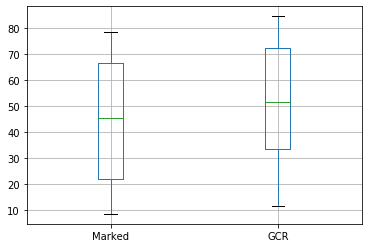

In [15]:
dataframeFinal_PSNR_Mean.boxplot()
# Higher values are achieved with GCR masking

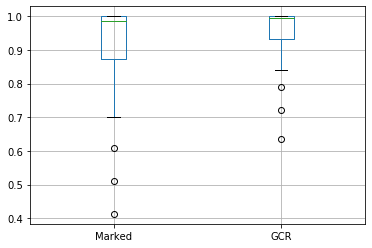

In [16]:
dataframeFinal_SSIM_Mean.boxplot()
# Higher values are achieved with GCR masking

In [ ]:
# https://www.dataquest.io/blog/making-538-plots/
style.use('fivethirtyeight')

# Creating Impact Factor / PSNR graph
fteGraph1 = dataframeFinal_PSNR_Mean_Marked.plot(x = 'Impact Factor', y = 'PSNR', figsize = (12, 8))
# Setting rules for labeling axes
fteGraph1.tick_params(axis = 'both', which = 'major', labelsize = 16)

# Creating different lines accross the graph (can be used for important slices of results)
fteGraph1.axhline(y = 40, color = 'black', linewidth = 1.1, alpha = .7)
fteGraph1.axhline(y = 45, color = 'black', linewidth = 1.1, alpha = .7)

# Setting visibility of X-label
fteGraph1.xaxis.label.set_visible(True)


# Title

# Y value is continuous to values on Y-axis. For instance, 
# if the maximum value is 60, the text can begin at 61.

# Alpha indicates text opacity

fteGraph1.text(x = 0, y = 97, s = "How Impact Factor affects PSNR Values",
               fontsize = 26, weight = 'bold', alpha = .7)

# Subtitle
fteGraph1.text(x = 0, y = 88.5,
               s = "For low Impact factor values, PSNR values are very high, but dropping down rapidly.\nWith larger Impact Factor values, PSNR values are still dropping, but not as rapidly.",
              fontsize = 18, alpha = .6)

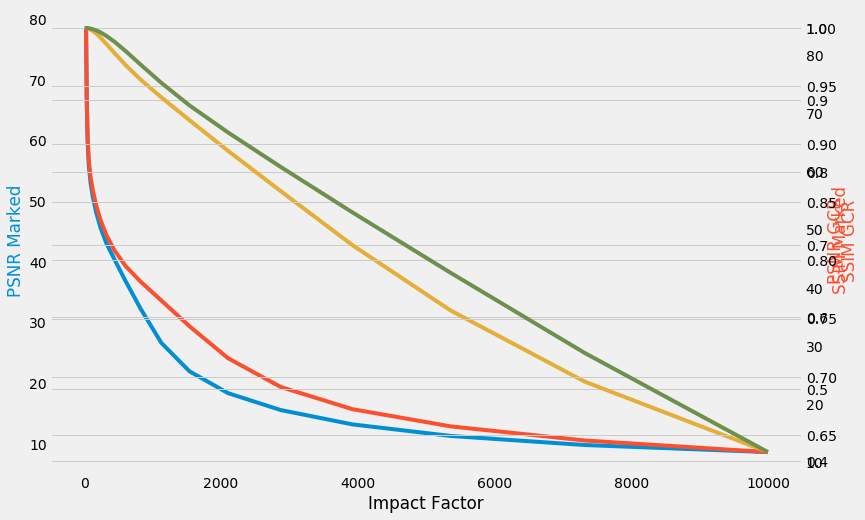

In [24]:
# Colors: https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle

plt.style.use('fivethirtyeight')

# Creating graph
fig, ax1 = plt.subplots(figsize=(12,8))

# Setting X-axis and first Y-axis
ax1.set_xlabel('Impact Factor')
ax1.set_ylabel('PSNR Marked', color = '#008fd5')

# Creating a second Y-axis that shares the same X-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('PSNR GCR', color = '#fc4f30')

# Creating a second Y-axis that shares the same X-axis
ax3 = ax1.twinx()  
ax3.set_ylabel('SSIM Marked', color = '#fc4f30')

# Creating a second Y-axis that shares the same X-axis
ax4 = ax1.twinx()  
ax4.set_ylabel('SSIM GCR', color = '#fc4f30')

# Show grid
ax1.grid(False)
ax2.grid(False)

# Setting different colors for each variable
ax1.plot(dataframeFinal_PSNR_Mean_Marked, color = '#008fd5')
ax2.plot(dataframeFinal_PSNR_Mean_GCR, color = '#fc4f30')
ax3.plot(dataframeFinal_SSIM_Mean_Marked, color = '#e5ae38')
ax4.plot(dataframeFinal_SSIM_Mean_GCR, color = '#6d904f')

plt.savefig('destination_path.eps', format="eps")